# Выпускной проект: Промышленность
Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. 

Задача — построить модель, которая будет предсказывать конечную температуру сплава после достижения целевого химического состава. 

Заказчик хочет использовать разработанную модель для имитации технологического процесса.

Объект моделирования - это металлический ковш вместимостью около 100 тонн, облицовыванный огнеупорным кирпичом, в который заливают расплавленную сталь.

Цель проекта - разработка модели машинного обучения для прогнозирования температуры стали на этапе обработки с целью оптимизации энергопотребления и снижения производственных затрат металлургического комбината «Стальная птица».

Исследование разделим на этапы:
1. Загрузка данных
2. Исследовательский анализ и предобработка данных
3. Объединение данных
4. Корреляционный анализ
5. Обучение моделей
6. Анализ важности признаков
7. Выводы

Данные состоят из нескольких файлов, полученных из разных источников:
- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

In [ ]:
# !pip install matplotlib==3.5.0 phik shap catboost -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from phik import phik_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
import shap

RANDOM_STATE = 30625

## Загрузка данных

In [3]:
def load_data(file_name, parse_dates=None):
    try:
        df= pd.read_csv(file_name, parse_dates=parse_dates, index_col=0)
    except:
        df = pd.read_csv(f'/datasets/{file_name}', parse_dates=parse_dates, index_col=0)
    return df

### Датасет *df_arc*

Рассмотрим подробнее датасет *df_arc*.

In [4]:
df_arc = load_data('data_arc_new.csv', [1, 2])

In [5]:
df_arc.head()

,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
key,,,,
1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [6]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14876 entries, 1 to 3241
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Начало нагрева дугой  14876 non-null  datetime64[ns]
 1   Конец нагрева дугой   14876 non-null  datetime64[ns]
 2   Активная мощность     14876 non-null  float64       
 3   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2)
memory usage: 581.1 KB


In [7]:
df_arc.describe().round(3)

,Активная мощность,Реактивная мощность
count,14876.000,14876.000
mean,0.663,0.439
std,0.259,5.873
min,0.223,-715.480
25%,0.467,0.337
50%,0.600,0.442
75%,0.830,0.608
max,1.464,1.270


In [8]:
df_arc.isna().sum()

Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

In [9]:
df_arc.shape

(14876, 4)

В датасете *df_arc* 14876 записей и 4 признака: `Начало нагрева дугой`, `Конец нагрева дугой`, `Активная мощность`, `Реактивная мощность`. Первые два признака datetime64[ns], вторые два призкана имеют тип данных float64. Пропусков в данных нет. Заметим, что в признаке `Реактивная мощность` имеется экстримально низкое значение, более подробно рассмотрим его на следующем этапе.

### Датасет *df_bulk*

Рассмотрим подробнее датасет *df_bulk*.

In [10]:
df_bulk = load_data('data_bulk_new.csv')

In [11]:
df_bulk.head()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [12]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 1 to 3241
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Bulk 1   252 non-null    float64
 1   Bulk 2   22 non-null     float64
 2   Bulk 3   1298 non-null   float64
 3   Bulk 4   1014 non-null   float64
 4   Bulk 5   77 non-null     float64
 5   Bulk 6   576 non-null    float64
 6   Bulk 7   25 non-null     float64
 7   Bulk 8   1 non-null      float64
 8   Bulk 9   19 non-null     float64
 9   Bulk 10  176 non-null    float64
 10  Bulk 11  177 non-null    float64
 11  Bulk 12  2450 non-null   float64
 12  Bulk 13  18 non-null     float64
 13  Bulk 14  2806 non-null   float64
 14  Bulk 15  2248 non-null   float64
dtypes: float64(15)
memory usage: 391.1 KB


In [13]:
df_bulk.describe().round(3)

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,252.000,22.000,1298.000,1014.000,77.000,576.000,25.000,1.0,19.000,176.000,177.000,2450.000,18.000,2806.000,2248.000
mean,39.242,253.045,113.879,104.394,107.026,118.925,305.600,49.0,76.316,83.284,76.819,260.471,181.111,170.285,160.513
std,18.278,21.181,75.483,48.184,81.791,72.058,191.023,NaN,21.721,26.060,59.655,120.649,46.088,65.869,51.765
min,10.000,228.000,6.000,12.000,11.000,17.000,47.000,49.0,63.000,24.000,8.000,53.000,151.000,16.000,1.000
25%,27.000,242.000,58.000,72.000,70.000,69.750,155.000,49.0,66.000,64.000,25.000,204.000,153.250,119.000,105.000
50%,31.000,251.500,97.500,102.000,86.000,100.000,298.000,49.0,68.000,86.500,64.000,208.000,155.500,151.000,160.000
75%,46.000,257.750,152.000,133.000,132.000,157.000,406.000,49.0,70.500,102.000,106.000,316.000,203.500,205.750,205.000
max,185.000,325.000,454.000,281.000,603.000,503.000,772.000,49.0,147.000,159.000,313.000,1849.000,305.000,636.000,405.000


In [14]:
df_bulk.isna().sum()

Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [15]:
df_bulk.shape

(3129, 15)

В датасете *df_bulk* 3129 записей и 15 признаков. В датасете большое количество пропусков, которые означают, что данную примесь не использовали для приведения стали к нормативному состоянию. Все столбцы имеют тип данных - float64. 

### Датасет *df_bulk_time*

Рассмотрим подробнее датасет *df_bulk_time*.

In [16]:
df_bulk_time = load_data('data_bulk_time_new.csv', list(range(1, 16)))

In [17]:
df_bulk_time.head()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


In [18]:
df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 1 to 3241
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Bulk 1   252 non-null    datetime64[ns]
 1   Bulk 2   22 non-null     datetime64[ns]
 2   Bulk 3   1298 non-null   datetime64[ns]
 3   Bulk 4   1014 non-null   datetime64[ns]
 4   Bulk 5   77 non-null     datetime64[ns]
 5   Bulk 6   576 non-null    datetime64[ns]
 6   Bulk 7   25 non-null     datetime64[ns]
 7   Bulk 8   1 non-null      datetime64[ns]
 8   Bulk 9   19 non-null     datetime64[ns]
 9   Bulk 10  176 non-null    datetime64[ns]
 10  Bulk 11  177 non-null    datetime64[ns]
 11  Bulk 12  2450 non-null   datetime64[ns]
 12  Bulk 13  18 non-null     datetime64[ns]
 13  Bulk 14  2806 non-null   datetime64[ns]
 14  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15)
memory usage: 391.1 KB


In [19]:
df_bulk_time.isna().sum()

Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [20]:
df_bulk_time.shape

(3129, 15)

По аналогии с датасетом *df_bulk* в *df_bulk_time* хранится информация о времени подачи сыпучих материалов. Пропуски означают, что материал добавлен в этот ковш не был. Все столбцы имеют тип данных - datetime64[ns].

### Датасет *df_gas*

Рассмотрим подробнее датасет *df_gas*.

In [21]:
df_gas = load_data('data_gas_new.csv')

In [22]:
df_gas.head()

,Газ 1
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692


In [23]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3239 entries, 1 to 3241
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Газ 1   3239 non-null   float64
dtypes: float64(1)
memory usage: 50.6 KB


In [24]:
df_gas.describe().round(3)

,Газ 1
count,3239.000
mean,11.002
std,6.220
min,0.008
25%,7.043
50%,9.836
75%,13.770
max,77.995


In [25]:
df_gas.isna().sum()

Газ 1    0
dtype: int64

In [26]:
df_gas.shape

(3239, 1)

В датасете *df_gas* 3239 записи и один признак - `Газ 1` с типом данных float64. Пропусков в данных нет.

### Датасет *df_temp*

Рассмотрим подробнее датасет *df_temp*.

In [27]:
df_temp = load_data('data_temp_new.csv', [1])

In [28]:
df_temp.head()

,Время замера,Температура
key,,
1,2019-05-03 11:02:04,1571.0
1,2019-05-03 11:07:18,1604.0
1,2019-05-03 11:11:34,1618.0
1,2019-05-03 11:18:04,1601.0
1,2019-05-03 11:25:59,1606.0


In [29]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18092 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Время замера  18092 non-null  datetime64[ns]
 1   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 424.0 KB


In [30]:
df_temp.describe().round(3)

,Температура
count,14665.000
mean,1590.723
std,20.394
min,1191.000
25%,1580.000
50%,1590.000
75%,1599.000
max,1705.000


In [31]:
df_temp.isna().sum()

Время замера       0
Температура     3427
dtype: int64

In [32]:
df_temp.shape

(18092, 2)

В датасете *df_temp* 2 признака: `Время замера` и `Температура` и 18092 записи. В данных о температуре 3427 пропуска.

### Датасет *df_wire*

Рассмотрим подробнее датасет *df_wire*.

In [33]:
df_wire = load_data('data_wire_new.csv')

In [34]:
df_wire.head()

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Wire 1  3055 non-null   float64
 1   Wire 2  1079 non-null   float64
 2   Wire 3  63 non-null     float64
 3   Wire 4  14 non-null     float64
 4   Wire 5  1 non-null      float64
 5   Wire 6  73 non-null     float64
 6   Wire 7  11 non-null     float64
 7   Wire 8  19 non-null     float64
 8   Wire 9  29 non-null     float64
dtypes: float64(9)
memory usage: 240.7 KB


In [36]:
df_wire.describe().round(3)

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3055.000,1079.000,63.000,14.000,1.000,73.000,11.000,19.000,29.000
mean,100.896,50.577,189.483,57.443,15.132,48.017,10.039,53.625,34.156
std,42.013,39.320,99.513,28.825,NaN,33.920,8.611,16.882,19.932
min,1.919,0.030,0.144,24.149,15.132,0.034,0.234,45.077,4.623
25%,72.116,20.194,95.135,40.807,15.132,25.054,6.763,46.095,22.058
50%,100.158,40.143,235.195,45.234,15.132,42.076,9.017,46.280,30.066
75%,126.060,70.228,276.252,76.125,15.132,64.213,11.886,48.090,43.862
max,330.314,282.780,385.009,113.231,15.132,180.455,32.848,102.762,90.054


In [37]:
df_wire.isna().sum()

Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

In [38]:
df_wire.shape

(3081, 9)

В датасете *df_wire* 3081 запись и 9 признаков. В датасете большое количество пропусков, которые означают, что данную проволку не использовали для приведения стали к нормативному состоянию. Все столбцы имеют тип данных - float64.

### Датасет *df_wire_time*

In [39]:
df_wire_time = load_data('data_wire_time_new.csv', list(range(1, 10)))

In [40]:
df_wire_time.head()

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [41]:
df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Wire 1  3055 non-null   datetime64[ns]
 1   Wire 2  1079 non-null   datetime64[ns]
 2   Wire 3  63 non-null     datetime64[ns]
 3   Wire 4  14 non-null     datetime64[ns]
 4   Wire 5  1 non-null      datetime64[ns]
 5   Wire 6  73 non-null     datetime64[ns]
 6   Wire 7  11 non-null     datetime64[ns]
 7   Wire 8  19 non-null     datetime64[ns]
 8   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9)
memory usage: 240.7 KB


In [42]:
df_wire_time.isna().sum()

Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

In [43]:
df_wire_time.shape

(3081, 9)

По аналогии с датасетом *df_wire* в *df_wire_time* хранится информация о времени подачи проволочных материалов. Пропуски означают, что материал добавлен в этот ковш не был. Все столбцы имеют тип данных - datetime64[ns].

### Вывод
1. **Основные характеристики датасетов:**

    - ***df_arc*** (14 876 записей, 4 признака): отсутствуют пропуски, но есть экстремально низкое значение в "Реактивной мощности".
    
    - ***df_bulk*** (3 129 записей, 15 признаков) и ***df_wire*** (3 081 запись, 9 признаков): содержат множество пропусков, связанных с отсутствием использования определённых примесей/проволоки.
    
    - ***df_temp*** (18 092 записи, 2 признака): значительное число пропусков температуры (3 427), что требует дополнительной обработки.
    
    - ***df_gas*** (3 239 записей, 1 признак) и временные датасеты (***df_bulk_time***, ***df_wire_time***) пропусков не имеют, но их пустые значения отражают отсутствие подачи материалов.

3. ***Типы данных:***

    - Временные признаки (начало/конец нагрева, время подачи) хранятся в формате **datetime64[ns]**.
    
    - Остальные данные (мощность, температура, объёмы материалов) — числовые (**float64**).

## Исследовательский анализ и предобработка данных

In [44]:
def num_plot(df, column, figsize=(8, 6)):
    fig, axes = plt.subplots(2, 1, figsize=figsize)
    sns.histplot(data=df, x=column, ax=axes[0], color='skyblue')
    axes[0].set_title(f'Гистограмма распределения признака {column}')
    axes[0].set_ylabel('Количество')
    sns.boxplot(data=df, x=column, ax=axes[1], color='skyblue', saturation=1)
    axes[1].set_title(f'Boxplot распределения признака {column}')
    plt.tight_layout()
    plt.show()

### Датасет *df_arc*

Рассмотрим датасет *df_arc*.

In [45]:
df_arc.head()

,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
key,,,,
1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


Построим гистограмму и ящик с усами для признака `Активная мощность`.

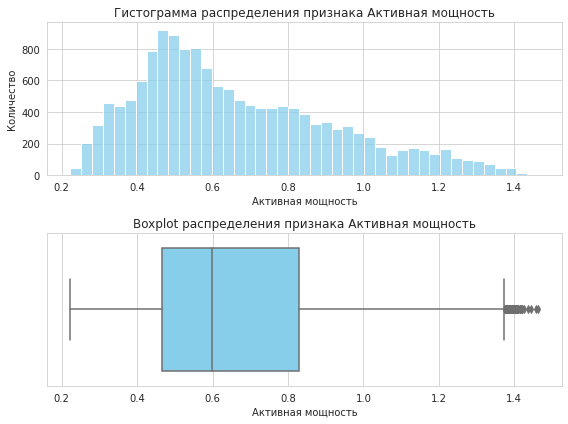

In [46]:
sns.set_style('whitegrid')
num_plot(df_arc, 'Активная мощность')

Видим, что распределение **правостороннее**, имеется "хвост" в сторону больших значений.

Подробнее рассмотрим выбросы в значениях признака `Реактивная мощность`.

In [47]:
df_arc[df_arc['Реактивная мощность'] < 0]

,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
key,,,,
2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Избавимся от всех данных данного ковша и построим графики распределения признака.

In [50]:
df_arc.drop(2116, inplace=True)

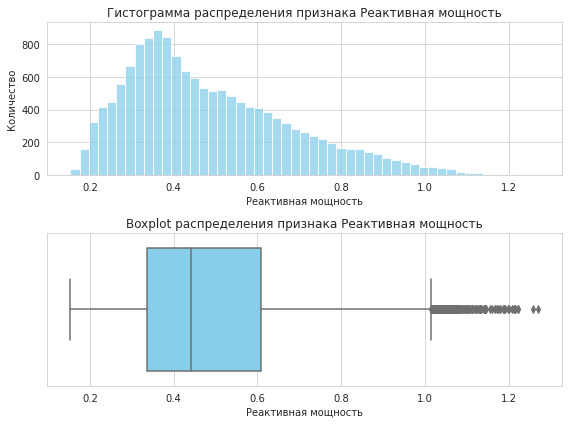

In [49]:
num_plot(df_arc, 'Реактивная мощность')

Видим, что распределение также **правостороннее** со скосом в сторону больших значений.

Добавим новые признаки в датасет, а именно: `Длительность нагрева дугой, c`, `Полная мощность` как корень из суммы квадратов активной и реактивной мощности, `Работа эл.тока` как произведение полной мощности на длительность нагрева и `Коэффициент реактивной мощности` как отношение реактивной мощности к активной. 

In [50]:
df_arc['Длительность нагрева дугой, c'] = (df_arc['Конец нагрева дугой'] - df_arc['Начало нагрева дугой']).dt.seconds
df_arc.head()

,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,"Длительность нагрева дугой, c"
key,,,,,
1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228
1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185
1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172
1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365
1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148


In [51]:
df_arc['Полная мощность'] = (df_arc['Активная мощность'] ** 2 + df_arc['Реактивная мощность'] ** 2) ** 0.5
df_arc.head()

,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,"Длительность нагрева дугой, c",Полная мощность
key,,,,,,
1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228,0.371123
1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185,0.902319
1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172,0.722536
1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365,0.642824
1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148,1.079934


In [52]:
df_arc['Работа эл.тока'] = df_arc['Полная мощность'] * df_arc['Длительность нагрева дугой, c']
df_arc.head()

,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,"Длительность нагрева дугой, c",Полная мощность,Работа эл.тока
key,,,,,,,
1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228,0.371123,84.616003
1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185,0.902319,166.928978
1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172,0.722536,124.276277
1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365,0.642824,234.630603
1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148,1.079934,159.830252


In [53]:
df_arc['Коэффициент мощности'] = df_arc['Активная мощность'] / df_arc['Полная мощность']
df_arc.head()

,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,"Длительность нагрева дугой, c",Полная мощность,Работа эл.тока,Коэффициент мощности
key,,,,,,,,
1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228,0.371123,84.616003,0.822181
1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185,0.902319,166.928978,0.848545
1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172,0.722536,124.276277,0.803161
1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365,0.642824,234.630603,0.806591
1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148,1.079934,159.830252,0.802950


Для объединения с другими таблицами суммируем все значения признаков с одинаковыми индексами, а также удалим из нашего датасета `Начало нагрева дугой` и `Конец нагрева дугой` т.к они не несут никакой полезной информации для модели, кроме длительности нагрева, которую мы уже вычислили.

In [54]:
df_arc = df_arc.drop(
    ['Начало нагрева дугой', 'Конец нагрева дугой'], axis=1
    ).groupby(level=0).agg('sum')

### Датасет *df_bulk*

Рассмотрим подробнее датасет *df_bulk*.

In [55]:
df_bulk.head()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Проверим, что датасеты *df_bulk* и *df_bulk_time* имеют заполненные значения и места пропусков, чтобы убедится, что нет опечаток и неправильных значений.

In [56]:
df_bulk.shape[0]

3129

In [57]:
(df_bulk.notna() == df_bulk_time.notna()).sum()

Bulk 1     3129
Bulk 2     3129
Bulk 3     3129
Bulk 4     3129
Bulk 5     3129
Bulk 6     3129
Bulk 7     3129
Bulk 8     3129
Bulk 9     3129
Bulk 10    3129
Bulk 11    3129
Bulk 12    3129
Bulk 13    3129
Bulk 14    3129
Bulk 15    3129
dtype: int64

Как видим, все заполненные ячейки и пропуски обоих датасетов совпадают, что говорит о корректности данных в них.

Добавим новый признак `Всего присадок` как сумму всех сыпучих материалов, добавленных в ковш.

In [58]:
df_bulk['Всего присадок'] = df_bulk.sum(axis=1)
df_bulk.head()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Всего присадок
key,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,553.0
2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,582.0
3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,544.0
4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,595.0
5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,584.0


### Датасет *df_gas*

Рассмотрим подробнее датасет *df_gas*. Для этого построим графики распределения признака объем объём подаваемого газа.

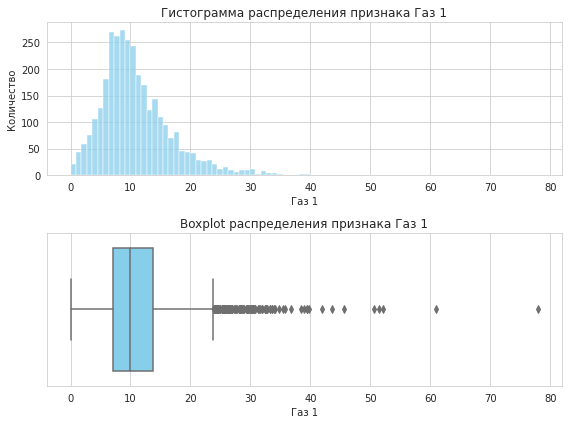

In [59]:
num_plot(df_gas, 'Газ 1')

Видим, что существуют заметные выбросы на графиках распределения, но мы не будем пытаться их удалять либо заменять, так как это может повлиять на предсказательную способность модели при редких, но случающихся на производстве случаях (например, большое количество итераций добавления материалов в ковш и, как следствие, большой объем необходимого газа в случае некачественной стали на входе)

Распределение данных имеет вид близкий к нормальному с хвостом в сторону больших значений.

### Датасет *df_temp*

Рассмотрим подробнее датасет *df_temp*. Для этого построим графики распределения признака `Температура`.

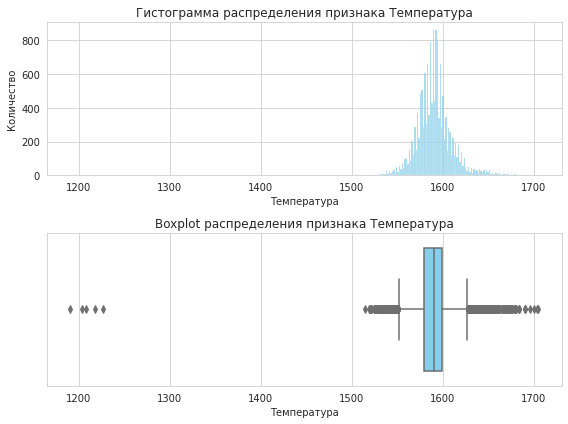

In [60]:
num_plot(df_temp, 'Температура')

Температура плавления стали находится в промежутке от 1350 до 1535°C в зависимости от хим. состава, за явные выбросы возьмем значения менее 1400°C и избавимся от данных о ковшах с такими температурами.

In [61]:
df_temp[df_temp['Температура'] < 1400]

,Время замера,Температура
key,,
867,2019-06-06 08:03:39,1191.0
1214,2019-06-18 08:01:03,1208.0
1619,2019-07-03 02:34:41,1218.0
2052,2019-07-25 08:49:15,1227.0
2561,2019-08-12 18:49:29,1204.0


In [62]:
df_temp = df_temp.drop(df_temp[df_temp['Температура'] < 1400].index).dropna()

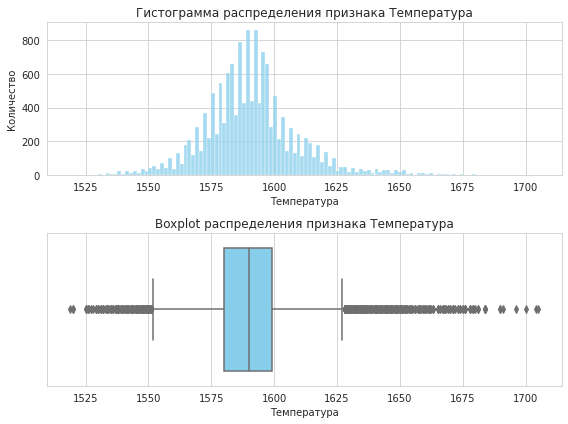

In [63]:
num_plot(df_temp, 'Температура')

Температура ковша имеет **нормальное** распределение.

In [64]:
df_temp.head(10)

,Время замера,Температура
key,,
1,2019-05-03 11:02:04,1571.0
1,2019-05-03 11:07:18,1604.0
1,2019-05-03 11:11:34,1618.0
1,2019-05-03 11:18:04,1601.0
1,2019-05-03 11:25:59,1606.0
1,2019-05-03 11:30:38,1613.0
2,2019-05-03 11:34:04,1581.0
2,2019-05-03 11:38:40,1577.0
2,2019-05-03 11:46:09,1589.0


Сгенерируем новый признак, который будет целевым в нашей задаче - это `Конечная температура`. Это температура сплава в ковше после всех итераций, т.е когда сталь преобретает требуемое качество.

Для этого сначала найдем в данных датасета *df_temp* только те индексы ковшей, в которых больше одной итерации, то есть в которых начальная и конечная температура будут отличаться, и используем только их.

In [65]:
print(f'Количество строк df_temp со всеми индексами: {len(df_temp)}')

Количество строк df_temp со всеми индексами: 14643


In [66]:
approp_index = df_temp.index.unique()[df_temp.groupby(level=0).size() > 1]
df_temp = df_temp.loc[approp_index]
print(f'Количество строк df_temp с подоходящими индексами: {len(df_temp)}')

Количество строк df_temp с подоходящими индексами: 13903


Для создания признака `Конечная температура` возьмем последнее значение столбца `Температура` для каждого индекса. Также избавимся от признака `Время замера`, т.к он неинформативен для нашей модели.

In [67]:
for ind in approp_index:
    df_temp.loc[ind, 'Конечная температура'] = df_temp.loc[ind].iloc[-1, 1]

In [68]:
df_temp = df_temp.groupby(level=0).first().loc[:, ['Температура', 'Конечная температура']]
print(df_temp.shape)
df_temp.head()

(2471, 2)


,Температура,Конечная температура
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0


Таким образом, получили 2471 строк с данными о ковшах, удовлетворяющих нашим условиям.

### Датасет *df_wire*

Рассмотрим подробнее датасет *df_wire* по аналогии с *df_bulk*.

In [69]:
df_wire.shape[0]

3081

In [70]:
(df_wire.notna() == df_wire_time.notna()).sum()

Wire 1    3081
Wire 2    3081
Wire 3    3081
Wire 4    3081
Wire 5    3081
Wire 6    3081
Wire 7    3081
Wire 8    3081
Wire 9    3081
dtype: int64

Данные в обоих датасетах *df_wire* и *df_wire_time* достоверные. Создадим новый признак `Всего проволоки` как сумму всех проволочных материалов для ковша.

In [71]:
df_wire['Всего проволоки'] = df_wire.sum(axis=1)
df_wire.head()

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Всего проволоки
key,,,,,,,,,,
1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.059998
2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.052315
3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.160157
4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.063515
5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.352796


### Вывод

Таким образом, в ходе исследовательского анализа и предобработки были проведены следующие действия:
1. **Анализ и очистка данных**

    - Проведена диагностика распределений ключевых признаков:
    
        - Выявлены правосторонние распределения с выбросами для энергетических параметров (`Активная мощность`, `Реактивная мощность`).
        
        - Удалены критические аномалии (например, явный выброс в `Реактивной мощности` и температуры <1400°C).
    
    - Для *df_bulk* и *df_wire* подтверждена корректность данных — пропуски соответствуют отсутствию добавления материалов.

2. **Генерация новых признаков**

    Созданы технологически значимые параметры:

    - Энергетические:
    
        - `Длительность нагрева дугой`
    
        - `Полная мощность`
        
        - `Работа эл.тока`
        
        - `Коэффициент реактивной мощности`
    
    - Материальные:
    
        - `Всего присадок` (суммарный объем сыпучих материалов)
        
        - `Всего проволоки` (суммарный объем проволочных добавок)
    
    - Целевая переменная:
    
        - `Конечная температура` (температура после последней итерации обработки).

3. **Оптимизация датасетов**

    - Удалены временные метки (`Начало/Конец нагрева дугой`, `Время замера`).
    
    - Сохранены выбросы в *df_gas*, отражающие реальные производственные случаи.

## Объединение данных

Объединим датасеты таким образом, чтобы в общий датасет *df* попали только данные о ковшах, которые есть во всех таблицах. Также в итоговый датасет не будет брать датасеты *df_bulk_time* и *df_wire_time* т.к они не дают никакой полезной информации для модели.

In [72]:
df = df_temp.join([df_arc, df_bulk, df_gas, df_wire], how='inner')
df.head()

,Температура,Конечная температура,Активная мощность,Реактивная мощность,"Длительность нагрева дугой, c",Полная мощность,Работа эл.тока,Коэффициент мощности,Bulk 1,Bulk 2,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Всего проволоки
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,3.036730,2.142821,1098,3.718736,770.282114,4.083428,NaN,NaN,...,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.059998
2,1581.0,1602.0,2.139408,1.453357,811,2.588349,481.760005,3.301105,NaN,NaN,...,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.052315
3,1596.0,1599.0,4.063641,2.937457,655,5.019223,722.837668,4.048621,NaN,NaN,...,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.160157
4,1601.0,1625.0,2.706489,2.056992,741,3.400038,683.455597,3.175691,NaN,NaN,...,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.063515
5,1576.0,1602.0,2.252950,1.687991,869,2.816980,512.169934,3.187274,NaN,NaN,...,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.352796


In [73]:
df.shape

(2324, 35)

Полученный датасет имеет 2324 записи и 35 признаков, исследуем их подробнее.

In [74]:
df.isna().sum()

Температура                         0
Конечная температура                0
Активная мощность                   0
Реактивная мощность                 0
Длительность нагрева дугой, c       0
Полная мощность                     0
Работа эл.тока                      0
Коэффициент мощности                0
Bulk 1                           2125
Bulk 2                           2311
Bulk 3                           1366
Bulk 4                           1513
Bulk 5                           2271
Bulk 6                           1887
Bulk 7                           2311
Bulk 8                           2323
Bulk 9                           2311
Bulk 10                          2181
Bulk 11                          2194
Bulk 12                           515
Bulk 13                          2310
Bulk 14                           260
Bulk 15                           628
Всего присадок                      0
Газ 1                               0
Wire 1                             23
Wire 2      

Как и ожидалось, пропуски в данных есть только в тех случаях, когда данный материал не был использован для доведения стали до нормативного состава, поэтому мы можем заменить пропуски нулями.

In [75]:
df.fillna(0, inplace=True)
df.head()

,Температура,Конечная температура,Активная мощность,Реактивная мощность,"Длительность нагрева дугой, c",Полная мощность,Работа эл.тока,Коэффициент мощности,Bulk 1,Bulk 2,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Всего проволоки
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,3.036730,2.142821,1098,3.718736,770.282114,4.083428,0.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
2,1581.0,1602.0,2.139408,1.453357,811,2.588349,481.760005,3.301105,0.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
3,1596.0,1599.0,4.063641,2.937457,655,5.019223,722.837668,4.048621,0.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
4,1601.0,1625.0,2.706489,2.056992,741,3.400038,683.455597,3.175691,0.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
5,1576.0,1602.0,2.252950,1.687991,869,2.816980,512.169934,3.187274,0.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796


### Вывод

В ходе объединения данных были проведены следующие действия:
1. Объединение датасетов
    - Использован метод **inner join**, что позволило сохранить только те ковши, которые присутствуют во всех исходных таблицах.
    - Итоговый датасет *df* содержит 2324 записи и 35 признаков.
2. Анализ пропущенных значений
    - Пропуски обнаружены только в столбцах, связанных с добавлением материалов: это **Bulk 1–15** (сыпучие материалы) и **Wire 1–9** (проволочные материалы). Это соответствует технологическому процессу: пропуски означают, что материал не использовался для конкретного ковша.
    - Пропуски заменены на 0, что логично интерпретируется как отсутствие добавления материала.

## Корреляционный анализ

Проведем корреляционный анализ для определения мультиколлинеарности между признаками. За мультиколлинеарность примем значения корреляции хи-квадрат более 0,9. 

In [76]:
def phik_matrix(df_matrix, figsize=(16, 10)):
    mask = np.triu(np.ones_like(df_matrix, dtype=bool))

    plt.figure(figsize=figsize)
    sns.heatmap(df_matrix, 
                mask=mask,
                annot=True, 
                fmt=".2f", 
                cmap='coolwarm',
                vmin=0, 
                vmax=1)
    plt.show()

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable Wire 5 for analysis 1. Dropping this column
  warnings.warn(


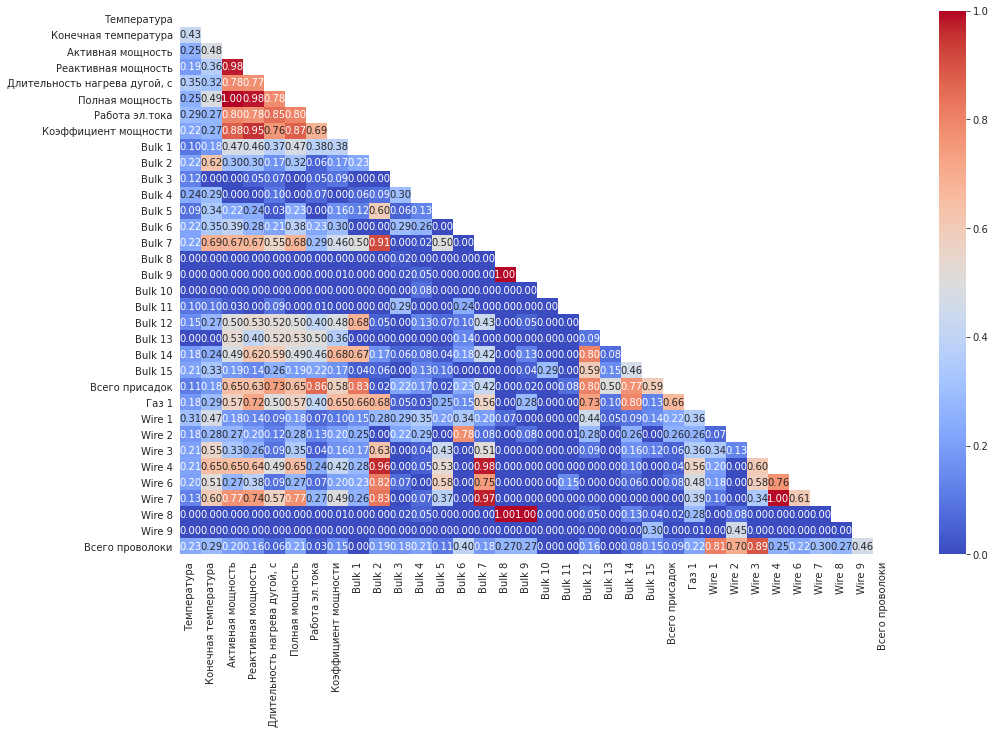

In [77]:
phik_matrix(df.phik_matrix(interval_cols=df.columns))

Исходя из представленных значений корреляции хи-квадрат делаем вывод, что признаки `Активная мощность`, `Реактивная мощность`, `Bulk 7`, `Bulk 9`, `Wire 4`, `Wire 7`, `Wire 8` мультиколлинеарны. Избавимся от этих признаков и построим заново матрицу корреляции. Также избавимся от признака `Wire 5` т.к в этом столбце все значения равны нулю.

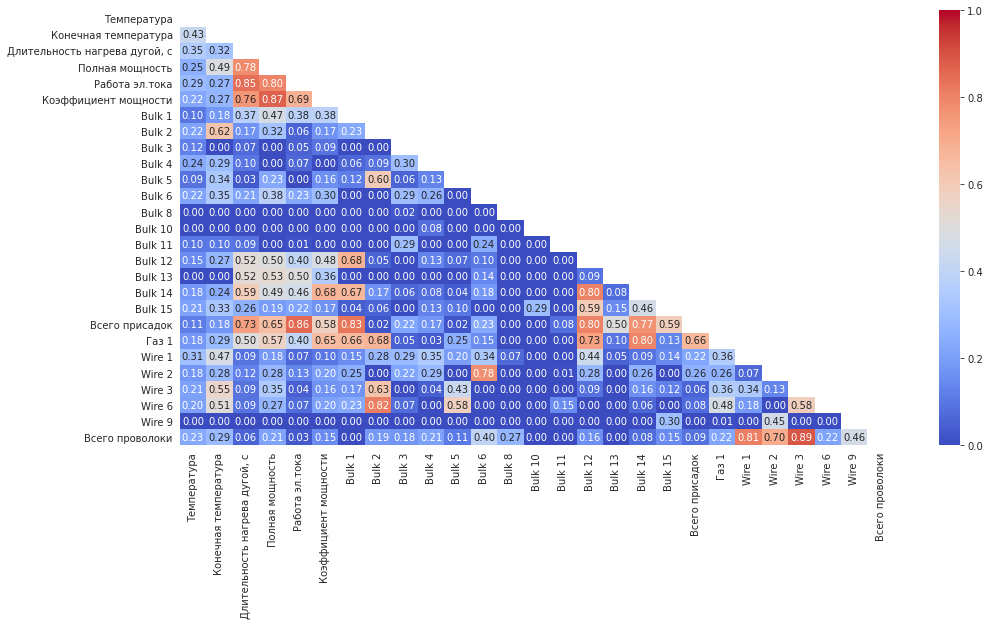

In [78]:
df = df.drop(['Активная мощность', 'Реактивная мощность', 'Bulk 7', 'Bulk 9', 'Wire 4', 'Wire 5', 'Wire 7', 'Wire 8'], axis=1)
phik_matrix(df.phik_matrix(interval_cols=df.columns), (16, 8))

### Вывод

Таким образом, в ходе корреляционного анализа были выполнены следующие действия:
- Обнаружена высокая корреляция (> 0.9) у следующих признаков: `Активная мощность`, `Реактивная мощность`, `Bulk 7`, `Bulk 9`, `Wire 4`, `Wire 7`, `Wire 8`.

- Признак `Wire 5` исключен из-за нулевой вариативности (все значения = 0), что делает его бесполезным для анализа.

- Удалены все выявленные мультиколлинеарные признаки для:

    - Улучшения интерпретируемости модели.
    
    - Повышения стабильности оценок коэффициентов.
    
    - Снижения риска переобучения.

- Построена новая корреляционная матрица для проверки оставшихся признаков.

## Обучение моделей

In [79]:
X = df.drop('Конечная температура', axis=1)
y = df['Конечная температура']

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

In [81]:
lr = LinearRegression()
lr_scores = cross_val_score(lr, X_train, y_train, 
                               cv=5,
                               scoring='neg_mean_absolute_error',
                               n_jobs=-1)

print(f'Cредний MAE LinearRegression при кросс-валидации: {-np.mean(lr_scores):.4f}')

Cредний MAE LinearRegression при кросс-валидации: 6.5814


In [82]:
# Класс-обертка для совместимости с GridSearchCV
class ModelWrapper(BaseEstimator):
    def __init__(self, model=None):
        self.model = model
    def fit(self, X, y):
        self.model.fit(X, y)
        return self
    def predict(self, X):
        return self.model.predict(X)

In [83]:
param_grid = [
    {
        'model': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10]
    },
    {
        'model': [CatBoostRegressor(verbose=0, random_state=RANDOM_STATE)],
        'model__iterations': [500, 1000],
        'model__depth': [4, 6, 8]
    }
]

In [84]:
gs = GridSearchCV(ModelWrapper(),
                 param_grid,
                 cv=5,
                 scoring='neg_mean_absolute_error',
                 n_jobs=-1)
gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=ModelWrapper(), n_jobs=-1,
             param_grid=[{'model': [RandomForestRegressor(random_state=30625)],
                          'model__max_depth': [None, 10],
                          'model__n_estimators': [100, 200]},
                         {'model': [<catboost.core.CatBoostRegressor object at 0x7f51af7ae4c0>],
                          'model__depth': [4, 6, 8],
                          'model__iterations': [500, 1000]}],
             scoring='neg_mean_absolute_error')

In [85]:
print(f'Лучшая модель и её параметры:\n {gs.best_params_}')
print (f'\nМетрика MAE лучшей модели при GridSearch кросс-валидации: {-gs.best_score_:.3f}')

Лучшая модель и её параметры:
 {'model': <catboost.core.CatBoostRegressor object at 0x7f51af7ae4c0>, 'model__depth': 6, 'model__iterations': 1000}

Метрика MAE лучшей модели при GridSearch кросс-валидации: 6.353


In [86]:
if -np.mean(lr_scores) < -gs.best_score_:
    best_model = lr
    print('\nЛучшая модель: LinearRegression')
else:
    best_model = gs.best_estimator_.model
    print(f"\nЛучшая модель: {best_model.__class__.__name__}")


Лучшая модель: CatBoostRegressor


In [87]:
y_pred = best_model.predict(X_test)
print(f'Результат лучшей модели {best_model.__class__.__name__} на тестовой выборке: {mean_absolute_error(y_test, y_pred):.3f}')

Результат лучшей модели CatBoostRegressor на тестовой выборке: 6.050


### Вывод

Таким образом, лучшая модель для наших данных - **CatBoostRegressor** c параметрами **'depth': 6, 'iterations': 1000**. Метрика качества модели MAE этой модели при кросс-валидации **6,353**, а на тестовой выборке - **6,050**.

## Анализ важности признаков

Для анализа важности признаков воспользуемся SHAP значениями.

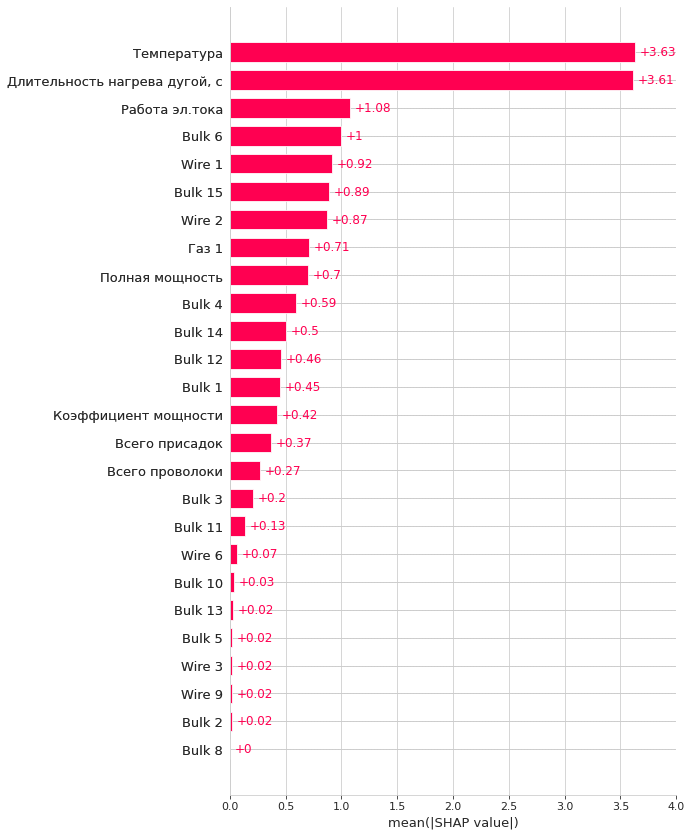

None

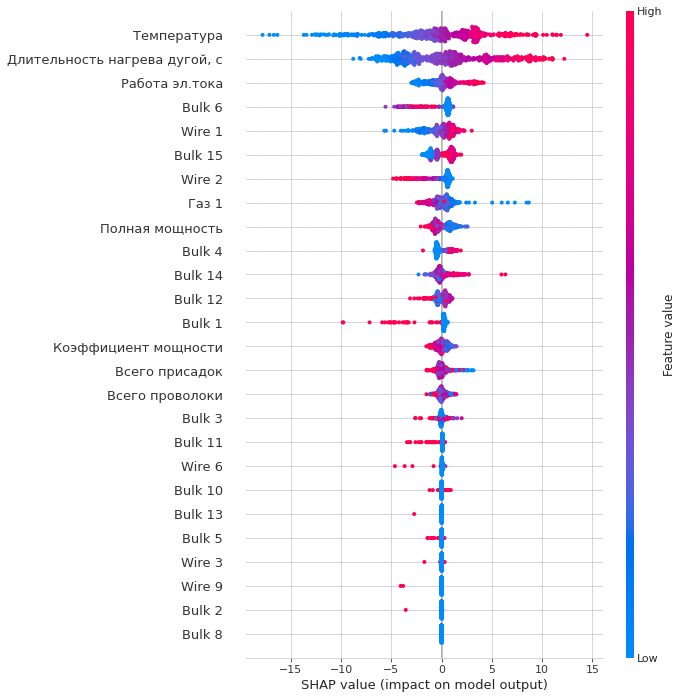

In [88]:
explainer = shap.TreeExplainer(best_model)

X_test_2 = pd.DataFrame(X_test, columns=X_test.columns)
 
shap_values = explainer(X_test_2)
 
display(shap.plots.bar(shap_values, max_display=30))
shap.plots.beeswarm(shap_values, max_display=30)

### Вывод

Таким образом, наиболее важными признаками для значения целевой переменной `Конечная температура` в нашей модели оказались: `Температура`, т.е. начальная температура до добавления материалов, `Длительность нагрева дугой, c` и `Работа эл.тока`, что хорошо соотносится с интуитивными предположениями о том, что больше всего может влиять на конечную температуру стали.

Факторы, которые оказывают наименьшее влияние на модель - это `Bulk 2`, `Bulk 8`, что говорит о том, что добавление этих сыпучих материалов не сказывается на конечной температуре стали.

## Общий вывод

**Основные этапы работы:**
1. **Загрузка и первичный анализ данных**

    - Изучены 6 датасетов, содержащих данные о:
        - Энергопотреблении (***df_arc***).
        - Добавках сыпучих материалов (***df_bulk***) и проволоки (***df_wire***).
        - Подаче газа (***df_gas***).
        - Температурных измерениях (***df_temp***).  
    - Выявлены:
        - Пропуски в данных (технологические и возможные ошибки).
        - Аномалии в распределениях (выбросы в мощности и температуре).

2. **Исследовательский анализ и предобработка данных**
    - Очистка от выбросов:
        - Удалены нереальные значения температуры (<1400°C).
        - Исключен экстремальный выброс в "Реактивной мощности".
    - Генерация новых признаков:
        - Технологические параметры: длительность нагрева, работа тока, суммарные объемы добавок.
        - Целевая переменная — "Конечная температура".
    - Оптимизация данных:
        - Удалены неинформативные столбцы (временные метки, нулевые признаки).
        - Замена пропусков нулями для материалов.
3. **Объединение и корреляционный анализ**
    - Создан единый датасет (**2324 записей × 35 признаков**) через **inner join**.
    - Выявлена и устранена мультиколлинеарность (корреляция > 0,9 для 7 признаков).
4. **Построение и оценка модели**
    - Протестированы 3 алгоритма: **LinearRegression**, **RandomForestRegressor**, **CatBoostRegressor**.
    - Лучшая модель: **CatBoostRegressor** (MAE = 6,353 на кросс-валидации, 6,050 на тесте).
    - Ключевые значимые признаки:
        - Начальная температура.
        - Длительность нагрева.
        - Работа электрического тока.

**Список признаков, используемых для обучения лучшей модели:**

- `Температура`
    
- `Длительность нагрева дугой, c`
    
- `Полная мощность`
    
- `Работа эл.тока`
    
- `Коэффициент мощности`
    
- `Bulk 1`
    
- `Bulk 2`
    
- `Bulk 3`
    
- `Bulk 4`
    
- `Bulk 5`
    
- `Bulk 6`
    
- `Bulk 8`
    
- `Bulk 10`
    
- `Bulk 11`
    
- `Bulk 12`
    
- `Bulk 13`
    
- `Bulk 14`
    
- `Bulk 15`
    
- `Всего присадок`
    
- `Газ 1`
    
- `Wire 1`
    
- `Wire 2`
    
- `Wire 3`
    
- `Wire 6`
    
- `Wire 9`
    
- `Всего проволоки`

**Гиперпараметры лучшей модели (CatBoostRegressor):** 'depth': 6, 'iterations': 1000, random_state=3062025

**Результат метрики качества модели MAE при кросс-валидации (на тесте):** 6,353 (6,050).

**Полученные результаты:**

- Подготовлен очищенный и оптимизированный датасет для моделирования.

- Построена стабильная модель прогнозирования температуры с ошибкой ~6.4°C.

- Выявлены наиболее влиятельные факторы на температуру:

    - Главные: исходная температура, длительность нагрева.
    
    - Незначимые: некоторые сыпучие материалы (Bulk 2, 5, 8).
 
**Рекомендации для бизнеса:**

1. **Контроль ключевых параметров**

    - Фокус на стабильности начальной температуры и точном расчете длительности нагрева — они сильнее всего влияют на результат.

2. **Оптимизация энергозатрат**

    - Анализ связи между "Работой эл.тока" и температурой поможет снизить потребление энергии без потери качества.
    
3. **Дальнейшее улучшение модели**

    - Тестирование на новых данных (например, при изменении состава стали).
        
    - Добавление физических закономерностей в признаки (например, теплоемкость материалов).
  
4. **Долгосрочные инициативы**

    - Добавьте данные о химическом составе стали для учета влияния примесей на температуру плавления.
        
    - Рассмотрим возможность добавления предиктивного обслуживание электродов — их износ коррелирует с реактивной мощностью.
